# Normalización de Tipos y Formatos  


## 0) Setup

In [31]:
import os, warnings, re
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 160)
pd.set_option("display.width", 220)



In [32]:
DATA_PATH = "listings.csv"

## 1) Carga y diagnóstico **antes**

In [33]:
df = pd.read_csv(DATA_PATH)
print("Cargado:", DATA_PATH, "| shape:", df.shape)
display(df.head(3))

Cargado: listings.csv | shape: (3818, 92)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [34]:
types_before = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "na_rate": df.isna().mean(),
    "nunique": df.nunique(dropna=False)
}).reset_index().rename(columns={"index":"column"})

types_before

,column,dtype,na_rate,nunique
0,id,int64,0.000000,3818
1,listing_url,object,0.000000,3818
2,scrape_id,int64,0.000000,1
3,last_scraped,object,0.000000,1
4,name,object,0.000000,3792
...,...,...,...,...
87,cancellation_policy,object,0.000000,3
88,require_guest_profile_picture,object,0.000000,2
89,require_guest_phone_verification,object,0.000000,2
90,calculated_host_listings_count,int64,0.000000,18


### 1.1 Quick check de columnas problemáticas (strings con $ o %)

In [35]:
problem_cols = [c for c in df.columns if c in ["price","cleaning_fee","security_deposit","extra_people","host_response_rate","host_acceptance_rate"]]
df[problem_cols].head(10) if problem_cols else print("No se detectaron columnas típicas problemáticas por nombre; continúa con el paso 2.")

,host_response_rate,host_acceptance_rate,price,security_deposit,cleaning_fee,extra_people
0,96%,100%,$85.00,NaN,NaN,$5.00
1,98%,100%,$150.00,$100.00,$40.00,$0.00
2,67%,100%,$975.00,"$1,000.00",$300.00,$25.00
3,NaN,NaN,$100.00,NaN,NaN,$0.00
4,100%,NaN,$450.00,$700.00,$125.00,$15.00
5,NaN,NaN,$120.00,NaN,$40.00,$30.00
6,100%,100%,$80.00,$150.00,NaN,$10.00
7,100%,100%,$60.00,$150.00,$25.00,$0.00
8,NaN,100%,$90.00,NaN,NaN,$0.00
9,98%,100%,$150.00,$100.00,$40.00,$0.00


## 2) Moneda a numérico (`price`, `cleaning_fee`, `security_deposit`, `extra_people`)

In [36]:
for col in ["price","cleaning_fee","security_deposit","extra_people"]:
    if col in df.columns:
        # Vista antes
        print(f"\n[{col}] ejemplos ANTES:")
        print(df[col].astype(str).head(5).tolist())

        # Conversión: quitar $ y comas
        s = df[col].astype(str)
        s = s.str.replace("$","",regex=False).str.replace(",","",regex=False).str.strip()
        df[col] = pd.to_numeric(s, errors="coerce")

        # Vista después
        print(f"[{col}] dtype DESPUÉS:", df[col].dtype)
        print(df[col].head(5).tolist())


[price] ejemplos ANTES:
['$85.00', '$150.00', '$975.00', '$100.00', '$450.00']
[price] dtype DESPUÉS: float64
[85.0, 150.0, 975.0, 100.0, 450.0]

[cleaning_fee] ejemplos ANTES:
['nan', '$40.00', '$300.00', 'nan', '$125.00']
[cleaning_fee] dtype DESPUÉS: float64
[nan, 40.0, 300.0, nan, 125.0]

[security_deposit] ejemplos ANTES:
['nan', '$100.00', '$1,000.00', 'nan', '$700.00']
[security_deposit] dtype DESPUÉS: float64
[nan, 100.0, 1000.0, nan, 700.0]

[extra_people] ejemplos ANTES:
['$5.00', '$0.00', '$25.00', '$0.00', '$15.00']
[extra_people] dtype DESPUÉS: float64
[5.0, 0.0, 25.0, 0.0, 15.0]


### 2.1 Visualización de `price` antes vs. después (si existe)

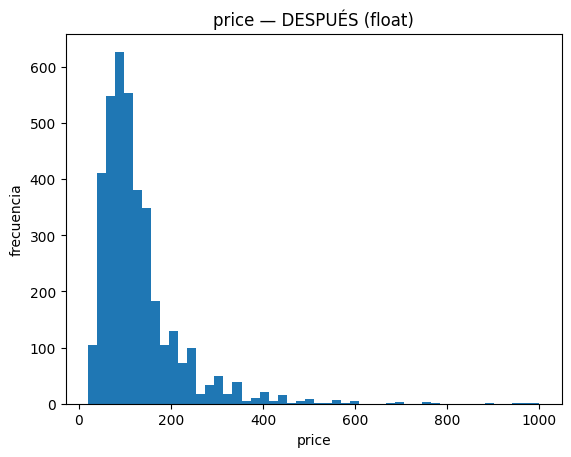

In [37]:
# Hist después (ya numérico)
plt.figure()
plt.hist(df["price"].dropna(), bins=50)
plt.title("price — DESPUÉS (float)")
plt.xlabel("price"); plt.ylabel("frecuencia")
plt.show()

## 3) Porcentajes a proporción [0,1] (`host_response_rate`, `host_acceptance_rate`)

In [38]:
for col in ["host_response_rate","host_acceptance_rate"]:
    if col in df.columns:
        print(f"\n[{col}] ejemplos ANTES:")
        print(df[col].astype(str).head(5).tolist())

        s = df[col].astype(str).str.replace("%","",regex=False).str.strip()
        s = pd.to_numeric(s, errors="coerce")
        df[col] = s / 100.0

        print(f"[{col}] dtype DESPUÉS:", df[col].dtype)
        print(df[col].head(5).tolist())


[host_response_rate] ejemplos ANTES:
['96%', '98%', '67%', 'nan', '100%']
[host_response_rate] dtype DESPUÉS: float64
[0.96, 0.98, 0.67, nan, 1.0]

[host_acceptance_rate] ejemplos ANTES:
['100%', '100%', '100%', 'nan', 'nan']
[host_acceptance_rate] dtype DESPUÉS: float64
[1.0, 1.0, 1.0, nan, nan]


## 4) Booleanos `t/f`/`true/false`/`yes/no` a `boolean`

In [40]:
df[["host_is_superhost","has_availability","instant_bookable","host_identity_verified"]]

,host_is_superhost,has_availability,instant_bookable,host_identity_verified
0,f,t,f,t
1,t,t,f,t
2,f,t,f,t
3,f,t,f,t
4,f,t,f,t
...,...,...,...,...
3813,f,t,f,t
3814,f,t,f,t
3815,f,t,f,f
3816,f,t,f,t


In [41]:
bool_map = {
    "t": True, "true": True, "1": True, "y": True, "yes": True,
    "f": False,"false": False,"0": False,"n": False,"no": False
}

for col in ["host_is_superhost","has_availability","instant_bookable","host_identity_verified"]:
    if col in df.columns:
        s = df[col].astype(str).str.lower().str.strip().replace(bool_map)
        s = s.mask(~s.isin([True, False]))
        df[col] = s.astype("boolean")
df[["host_is_superhost","has_availability","instant_bookable"]].head(5) if set(["host_is_superhost","has_availability","instant_bookable"]).issubset(df.columns) else None

,host_is_superhost,has_availability,instant_bookable
0,False,True,False
1,True,True,False
2,False,True,False
3,False,True,False
4,False,True,False


## 5) Fechas en cadenas a `datetime64[ns]` (`host_since`, `last_review`, `calendar_last_scraped`)

In [42]:
df[["host_since","last_review","calendar_last_scraped"]]

,host_since,last_review,calendar_last_scraped
0,2011-08-11,2016-01-02,2016-01-04
1,2013-02-21,2015-12-29,2016-01-04
2,2014-06-12,2015-09-03,2016-01-04
3,2013-11-06,NaN,2016-01-04
4,2011-11-29,2015-10-24,2016-01-04
...,...,...,...
3813,2015-04-13,2015-09-27,2016-01-04
3814,2015-10-14,2015-12-24,2016-01-04
3815,2015-12-30,NaN,2016-01-04
3816,2015-01-03,NaN,2016-01-04


In [43]:
df[["host_since","last_review","calendar_last_scraped"]].dtypes

,0
host_since,object
last_review,object
calendar_last_scraped,object


In [44]:
for col in ["host_since","last_review","calendar_last_scraped"]:
    if col in df.columns:
        parsed = pd.to_datetime(df[col], errors="coerce", dayfirst=False, utc=False)
        print(col, "parse success:", parsed.notna().mean())
        df[col] = parsed
df[["host_since","last_review"]].head(5) if set(["host_since","last_review"]).issubset(df.columns) else None

host_since parse success: 0.9994761655316919
last_review parse success: 0.8357778941854374
calendar_last_scraped parse success: 1.0


,host_since,last_review
0,2011-08-11,2016-01-02
1,2013-02-21,2015-12-29
2,2014-06-12,2015-09-03
3,2013-11-06,NaT
4,2011-11-29,2015-10-24


## 6) Otras numéricas típicas a tipos adecuados

In [47]:
df[["minimum_nights","maximum_nights","availability_365","number_of_reviews","review_scores_rating","bedrooms","beds"]].head(5)

,minimum_nights,maximum_nights,availability_365,number_of_reviews,review_scores_rating,bedrooms,beds
0,1,365,346,207,95.0,1.0,1.0
1,2,90,291,43,96.0,1.0,1.0
2,4,30,220,20,97.0,5.0,7.0
3,1,1125,143,0,NaN,0.0,2.0
4,1,1125,365,38,92.0,3.0,3.0


In [46]:
df[["minimum_nights","maximum_nights","availability_365","number_of_reviews","review_scores_rating","bedrooms","beds"]].dtypes

,0
minimum_nights,int64
maximum_nights,int64
availability_365,int64
number_of_reviews,int64
review_scores_rating,float64
bedrooms,float64
beds,float64


In [48]:
for col in ["minimum_nights","maximum_nights","availability_365","number_of_reviews","review_scores_rating","bedrooms","beds"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        if col in ["minimum_nights","maximum_nights","availability_365","number_of_reviews","bedrooms","beds"]:
            df[col] = df[col].round().astype("Int64")
df[["minimum_nights","maximum_nights","availability_365"]].head(5) if set(["minimum_nights","maximum_nights","availability_365"]).issubset(df.columns) else None

,minimum_nights,maximum_nights,availability_365
0,1,365,346
1,2,90,291
2,4,30,220
3,1,1125,143
4,1,1125,365


## 7) Texto/categóricas a normalización ligera y `category` para baja cardinalidad

In [49]:
# Normalización simple de 'neighbourhood_cleansed' y 'room_type' si existen
if "neighbourhood_cleansed" in df.columns:
    s = df["neighbourhood_cleansed"].astype(str).str.strip().str.lower().str.replace(r"\s+"," ", regex=True)
    df["neighbourhood_cleansed_norm"] = s.replace({"": pd.NA})
if "room_type" in df.columns and df["room_type"].nunique(dropna=False) <= 50:
    df["room_type"] = df["room_type"].astype("category")

df[["neighbourhood_cleansed","neighbourhood_cleansed_norm"]].head(10) if "neighbourhood_cleansed" in df.columns else None

,neighbourhood_cleansed,neighbourhood_cleansed_norm
0,West Queen Anne,west queen anne
1,West Queen Anne,west queen anne
2,West Queen Anne,west queen anne
3,West Queen Anne,west queen anne
4,West Queen Anne,west queen anne
5,West Queen Anne,west queen anne
6,West Queen Anne,west queen anne
7,West Queen Anne,west queen anne
8,West Queen Anne,west queen anne
9,West Queen Anne,west queen anne


## 8) Diagnóstico **después** y comparación

In [50]:
types_after = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "na_rate": df.isna().mean(),
    "nunique": df.nunique(dropna=False)
}).reset_index().rename(columns={"index":"column"})

summary = (types_before["dtype"].value_counts()
           .to_frame("before").join(types_after["dtype"].value_counts().to_frame("after"), how="outer").fillna(0).astype(int))
summary

,before,after
dtype,,
Int64,0,6
boolean,0,4
category,0,1
datetime64[ns],0,3
float64,17,21
int64,13,9
object,62,49
